# Ejercicios sobre diferenciación automática

In [1]:
import numpy as np

## 1. Modo Forward

Realiza la gráfica computacional para la función $f:\mathbb{R}^2 \to \mathbb{R}^2$ definida por:

$$f(x) =
\begin{pmatrix}
\ln(x_1^2) + 2x_2 \\
\cos(\ln(x_1^2) + x_2^2) \\
\end{pmatrix}
$$

Y obtén el gradiente de la función utilizando el modo forward. Ejemplifica con la entrada $x = (2, 5)$.

#### Definición de clases

In [2]:
class Node:
    def __init__(self, value, grad=1):
        self.value = value
        self.grad = grad

    def __str__(self):
        return str(self.value)
        
    def forward(self):
        self.grad = self.grad

In [3]:
class Ln:
    def __init__(self):
        self.grad = None

    def __call__(self, x):
        # Realiza la función
        self.value = np.log(x.value)
        self.parent = x
        return self

    def __str__(self):
        return str(self.value)

    def forward(self):
        self.parent.forward()
        node_grad = 1 / self.parent.value  # Derivada de ln(x)
        self.grad = node_grad * self.parent.grad  # Regla de la cadena
        return self.grad


In [4]:
class Cos:
    def __init__(self, n=2):
        self.n = n
        self.grad = None

    def __call__(self, x):
        self.value = np.cos(self.n*x.value)
        self.parent = x
        
        return self

    def __str__(self):
        return str(self.value)

    def forward(self):
        self.parent.forward()
        node_grad = -self.n*np.sin(self.n*self.parent.value)  # Derivada de cos(nx)
        self.grad = node_grad*self.parent.grad # Regla de la cadena
        
        return self.grad

In [5]:
class Pow:
    def __init__(self, p=2):
        self.pow = p
        self.grad = None

    def __call__(self, x):
        self.value = x.value**self.pow
        self.parent = x
        return self

    def __str__(self):
        return str(self.value)

    def forward(self):
        self.parent.forward()
        node_grad = self.pow*(self.parent.value**(self.pow-1)) # Derivada de x^n
        self.grad = node_grad*self.parent.grad # Regla de la cadena
        
        return self.grad

In [6]:
class Sum:
    def __init__(self):
        self.grad = None

    def __call__(self, x, y):
        self.value = x.value + y.value
        self.parentA = x
        self.parentB = y
        
        return self

    def __str__(self):
        return str(self.value)

    def forward(self):
        self.parentA.forward()
        self.parentB.forward()
        self.grad = self.parentA.grad + self.parentB.grad # Derivada 1, y regla de la cadena
        
        return self.grad

In [7]:
class ScalarMult:
    def __init__(self, c):
        self.c = c
        self.grad = None

    def __call__(self, x):
        self.value = self.c * x.value
        self.parent = x
        return self

    def __str__(self):
        return str(self.value)

    def forward(self):
        self.parent.forward()
        node_grad = self.c  # Derivada de c * x
        self.grad = node_grad * self.parent.grad  # Regla de la cadena
        return self.grad


In [8]:
class FunctionR2R2:
    def __init__(self):
        self.grad = None

    def __call__(self, node1, node2):
        self.node1 = node1
        self.node2 = node2
        self.value = (node1.value, node2.value)
        return self
    
    def __str__(self):
        return str(self.value)
    
    def forward(self):
        self.node1.forward()
        self.node2.forward()
        self.grad = (self.node1.grad, self.node2.grad)
        return self.grad


#### Implementación

In [9]:
# Parámetros iniciales
val_x, val_y = 2,5
grad_x, grad_y = 1,1

#Nodos de entrada x,y
x = Node(val_x, grad=grad_x)
y = Node(val_y, grad=grad_y)

# Potencia nodo 1
pow1 = Pow(p=2)
# Potencia nodo 2
pow2 = Pow(p=2)
# Nodo de operación coseno
cos = Cos(n=1)
# Logaritmo Natural nodo 1
mult2 = ScalarMult(2)
# Logaritmo Natural nodo 1
logn = Ln()
# Nodo de suma salida 1
sum1 = Sum()
# Nodo de suma salida 2
sum2 = Sum()
# Nodo de función a R^2
r2out = FunctionR2R2()

#Construcción de la gráfica dinámica
result = r2out( sum1(logn(pow1(x)), mult2(y)), cos( sum2(logn(pow1(x)), pow2(y)) ))
print(f'f{(val_x,val_y)} = ', result)

f(2, 5) =  (11.38629436111989, 0.31194851105961413)


In [10]:
jacob_t_vect = result.forward()
# Test 
assert jacob_t_vect[0] == 2/val_x * (grad_x) + 2*(grad_y)
assert jacob_t_vect[1] == -2*np.sin(np.log(val_x**2)+val_y**2)/val_x * (grad_x) - 2*val_y*np.sin(np.log(val_x**2)+val_y**2)*(grad_y)

print('Gradiente: ', jacob_t_vect)


Gradiente:  (3.0, -10.45108909636553)


## 2. Modo Reverse

A partir de la gráfica computacional dada con los nodos Linear, Softmax y CrossEntropy, crea la
gráfica computacional para el problema de la regresión logística:

$$f(x) = \sigma(\omega x + b)$$

Donde $\sigma$ es la función softmax y $\omega$ y $b$ los parámetros a aprender. Cálcula el gradiente utilizando
la función objetivo de entropía cruzada y actualiza los pesos por medio del método de ascenso por gradiente:

$$\theta \leftarrow \theta - \eta \nabla \partial(\theta)$$

donde $\eta$ es la taza de aprendizaje.

Utiliza el dataset de Iris de sklearn, y recuerda realizar la separación de 70-30 en los datos de
entrenamiento y evaluación. Asimismo, evalúa utilizando classification_report.

- Se recuerdan las clases del trabajo 2:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


- Linear

In [12]:
class Linear:
    '''
    Linear wx+b donde w y b se inician de forma aleatoria. 
    Debe tomar como argumentos el tamaño de entrada del vector y el de salida.
    '''
    def __init__(self, input_size, output_size):
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.grad_w = np.ones_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        self.value = None

    def __call__(self, x):
        x = set_node(x)
        self.value = np.dot(self.w, x.value) + self.b
        self.parent = x
        return self

    def backward(self, grad):
        self.grad_w = np.outer(grad, self.parent.value)
        self.grad_b = grad
        self.grad = np.dot(self.w.T, grad)
        self.parent.backward(self.grad)

- Softmax

Para definir el `self.grad` en este caso, se obtuvo por casos, ya que 

$$ \sigma(x_i) = \frac{e^{x}_i}{\sum_{j} e^{x}_j}$$

Caso 1: $i=j$

$$\frac{\partial \sigma(x_i)}{\partial x_i} = \sigma(x_i) (1 - \sigma(x_i))$$

Caso 1: $i\neq j$

$$\frac{\partial \sigma(z_i)}{\partial z_k} = -\sigma(z_i) \sigma(z_k)$$

Por lo que cuando los valores cuando $i=j$ se pueden representar como la diagonal de una matriz (`np.diagflat(s)`); mientras que los demás son los términos cruzados (`np.dot(s, s.T)`).

In [13]:
class Softmax:
    '''
    Función de activación.
    '''
    def __init__(self):
        self.value = None
        self.grad = None

    def __call__(self, x):
        x = set_node(x)
        e_x = np.exp(x.value - np.max(x.value))
        self.value = e_x / e_x.sum()
        self.parent = x
        return self

    def backward(self, grad):
        s = self.value.reshape(-1, 1)
        jacobian_m = np.diagflat(s) - np.dot(s, s.T)
        self.grad = np.dot(jacobian_m, grad)
        self.parent.backward(self.grad)

- CrossEntropy

En este caso

$$R(x) = - \sum_j \delta_{j,y} \ln x_j,$$

pero se omite la suma ya que sólo se considera el término no nulo que, para el caso del conjunto Iris, proviene de una única etiqueta (índice).

In [14]:
class CrossEntropy:
    def __init__(self):
        self.value = None
        self.grad = None

    def __call__(self, x, y):
        '''
        Suponiendo sólo un índice (etiqueta) en y,
        sólo habrá un valor no nulo de la función
        de CrossEntropy y se omite la suma.
        '''
        x = set_node(x)
        epsilon = 1e-15
        x_clip = np.clip(x.value, epsilon, None)
        self.value = -np.log(x_clip[y])
        self.parentA = x
        self.parentB = y
        return self

    def backward(self):
        grad = np.zeros_like(self.parentA.value)
        grad[self.parentB] = -1 / self.parentA.value[self.parentB]
        self.grad = grad
        self.parentA.backward(self.grad)

- Nodo

In [15]:
def set_node(x):
    '''
    Crea un nodo si x no es de ningún tipo de nodo en la red.
    Esto es necesario para instanciar los x_i obtenidos de
    la partición X_train, pues son de tipo array.
    '''
    if not isinstance(x, (Node, Linear, Softmax, CrossEntropy)):
        x = Node(x)
    return x

class Node:
    def __init__(self, value):
        self.value = value
        self.grad = None

    def __str__(self):
        return str(self.value)
        
    def backward(self, grad=1):
        self.grad = grad

- implementación

100%|██████████| 100/100 [00:00<00:00, 251.43it/s]


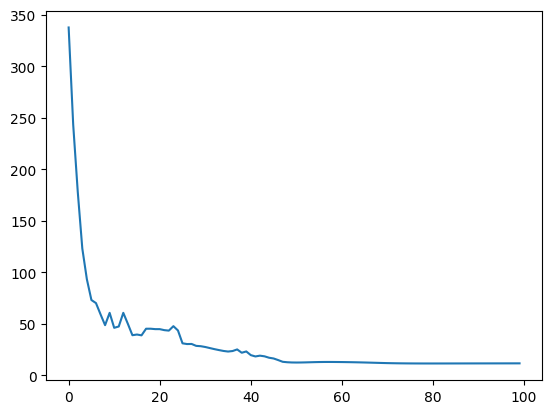

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.97        45
weighted avg       0.98      0.98      0.98        45



In [16]:
# Por reproducibilidad
np.random.seed(42)
random.seed(42)

# Cargar los datos de Iris
data = load_iris()
x = data.data
y = data.target

dim = len(data.feature_names)
classes = len(data.target_names)

# Dividir los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Inicializar las capas del modelo
lin1 = Linear(dim, classes)
soft = Softmax()
risk = CrossEntropy()

epochs = 100
lr = 0.1
total_loss = []

# Entrenamiento del modelo
for t in tqdm(range(epochs)):
    epoch_loss = 0
    for x_i, y_i in zip(x_train, y_train):
        pred = soft(lin1(x_i))
        loss = risk(pred, y_i)
        
        loss.backward()
        lin1.w -= lr * lin1.grad_w
        lin1.b -= lr * lin1.grad_b
        epoch_loss += loss.value
    total_loss.append(epoch_loss)

# Graficar la pérdida total por época
plt.plot(total_loss)
plt.show()

# Evaluar el modelo en el conjunto de prueba
test_pred = [soft(lin1(x_i)).value.argmax() for x_i in x_test]
print(classification_report(test_pred, y_test))
